In [8]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
import pandas as pd
from netCDF4 import Dataset
import os
import glob
from datetime import datetime
import seaborn as sns
import netCDF4
from netCDF4 import Dataset
from metpy.units import units
import dask
import dask.dataframe as dd
from dask.distributed import Client
import xarray as xr
from scipy.interpolate import griddata
from scipy.stats import circmean

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline

# Open BARRA 850hPa wind datasets

In [9]:
barra_towns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_townsville.nc", engine="h5netcdf",chunks="auto")
barra_cairns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_cairns.nc", engine="h5netcdf",chunks="auto")
barra_willis = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_willis_island.nc", engine="h5netcdf",chunks="auto")

0.3.0


In [11]:
def calc_mean_wdir(ds):
    radian = np.deg2rad(ds)
    circmean_ds = circmean(radian,high=(2*np.pi),low=0,nan_policy='omit')
    wdir_mean = np.rad2deg(circmean_ds)
    return wdir_mean
print('Mean BARRA2 Townsville wind direction: ',calc_mean_wdir(barra_towns.wind_dir))

Mean BARRA2 Townsville wind direction:  110.81416388682412


In [56]:
def diurnal_cycle(ds,winds=None):
    morning = [18,19,20]
    four_am = ds.sel(time=ds.time.dt.hour.isin(morning)) #18 UTC = 4am AEST
    afternoon = [4,5,6] #2-4pm
    four_pm = ds.sel(time=ds.time.dt.hour.isin(afternoon)) #6 UTC = 4pm AEST
    
    # create for loop 
    hourly = ds.groupby(ds.time.dt.hour)
    mean_hourly = []
    if winds==True:
        for hour in range(len(hourly)):
            print(len(hourly[hour]))
            values = hourly[hour].values
            mean = calc_mean_wdir(values)
            mean_hourly.append(mean) 
    else:
        for hour in range(len(hourly)):
            values = hourly[hour].dropna(dim='time').values
            mean = np.mean(values)
            mean_hourly.append(mean) 
    mean_hourly_AEST = np.roll(mean_hourly, shift=10)
    return mean_hourly_AEST, four_am, four_pm 

In [57]:
# townsville
mean_hourly_wdir_AEST_T,four_am_wdirT,four_pm_wdirT = diurnal_cycle(wind_dir_towns,winds=True)
mean_hourly_wspd_AEST_T,four_am_wspdT,four_pm_wspdT = diurnal_cycle(wind_speed_towns,winds=False)
# cairns
# mean_hourly_wdir_AEST_C,four_am_wdirC,four_pm_wdirC = diurnal_cycle(wind_dir_cairns,winds=True)
# mean_hourly_wspd_AEST_C,four_am_wspdC,four_pm_wspdC = diurnal_cycle(wind_speed_cairns,winds=False)

1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262
1262


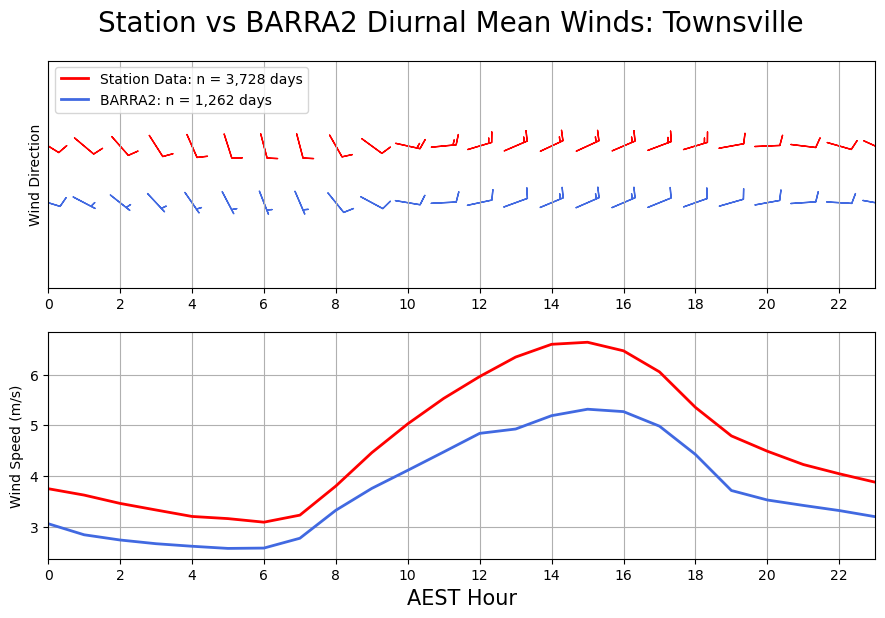

In [84]:
# plot
fig,ax = plt.subplots(2,1, figsize=[9,6])
fig.patch.set_facecolor('white')
fig.suptitle('Station vs BARRA2 Diurnal Mean Winds: Townsville',fontsize=20)
fig.tight_layout()

# plot wind direction as arrows
wind_direction_degrees = np.array(mean_hourly_wdir_AEST_T + 180)
wind_direction_radians = np.radians(90 - wind_direction_degrees)
wind_speed = np.array(mean_hourly_wspd_AEST_T)
station_wind_direction_degrees = np.array(station_mean_hourly_wdir_AEST_T + 180)
station_wind_direction_radians = np.radians(90 - station_wind_direction_degrees)
station_wind_speed = np.array(station_mean_hourly_wspd_AEST_T)

# plot wind barbs
barb_length = 6  # Adjust the barb length as needed
ax[0].barbs(range(len(wind_direction_degrees)), [-0.5] * len(wind_direction_degrees), wind_speed * np.cos(wind_direction_radians), wind_speed * np.sin(wind_direction_radians),
          barb_increments=dict(half=2, full=4, flag=20), length=barb_length,pivot='middle',color='royalblue',flip_barb=True)
ax[0].barbs(range(len(station_wind_direction_degrees)), [0.5] * len(station_wind_direction_degrees), station_wind_speed * np.cos(station_wind_direction_radians), station_wind_speed * np.sin(station_wind_direction_radians),
          barb_increments=dict(half=2, full=4, flag=20), length=barb_length,pivot='middle',color='red',flip_barb=True)
ax[1].plot(np.arange(0,24,1),station_mean_hourly_wspd_AEST_T,linewidth=2,color='red',label='Station Data: n = 3,728 days')
ax[1].plot(np.arange(0,24,1),mean_hourly_wspd_AEST_T,linewidth=2,color='royalblue',label='BARRA2: n = 1,262 days')
ax[0].set_ylabel('Wind Direction')
ax[1].set_ylabel('Wind Speed (m/s)')
ax[0].set_ylim(-2,2)
ax[0].set_xlim(0,23)
ax[1].set_xlim(0,23)
# ax[1].set_ylim(0,7)
ax[0].set_yticks([])
ax[0].set_yticklabels([])
ax[0].set_xticks(np.arange(0,24,2))
ax[1].set_xticks(np.arange(0,24,2))
# ax[0].set_title('Wind Direction')
# ax[1].set_title('Wind Speed')
ax[1].set_xlabel('AEST Hour',fontsize=15)
plt.legend(loc='upper left', bbox_to_anchor=(0, 2.2))
ax[0].grid(axis='both')
ax[1].grid(axis='both')
# plt.annotate('n = 3,728 days',(20,5));

# BOM station data

In [41]:
# file path
station_fp = '/g/data/w40/clv563/BoM_data/AWS-data-QLD.nc'
# open with xarray and dask chunking
station_ds = xr.open_dataset(station_fp, engine="h5netcdf", chunks="auto")

# find station IDs for Townsville & Cairns
bmid_townsville = station_ds.bmid[30] # BOM ID: 032040
bmid_cairns = station_ds.bmid[21]     # BOM ID: 031011

# Selecting for station IDs, select and add units to variables
townsville_wdir = station_ds.wdir.sel(station=30) * units("degrees")
townsville_wspd = (station_ds.wspd.sel(station=30) * (1000/(60*60))) *  units("m/s")
townsville_precip = station_ds.prec.sel(station=30)
townsville_temp = station_ds.temp.sel(station=30)
townsville_mslp = station_ds.mslp.sel(station=30)
# cairns
cairns_wdir = station_ds.wdir.sel(station=21) * units("degrees")
cairns_wspd = (station_ds.wspd.sel(station=21) * (1000/(60*60))) *  units("m/s")
cairns_precip = station_ds.prec.sel(station=21)
cairns_temp = station_ds.temp.sel(station=21)
cairns_mslp = station_ds.mslp.sel(station=21)

In [42]:
def JFMA_data(ds):
    var_jan_to_apr = [] # to append data
    years = np.arange(1990,2021,1) # available years of data
    for year in years:
        year_str = str(year)
        var_jfma = ds.sel(time=slice(year_str+'-01-01',year_str+'-04-30'))
        var_jan_to_apr.append(var_jfma)
    return xr.concat(var_jan_to_apr, dim='time').compute()
# townsville variables
wdirT = JFMA_data(townsville_wdir)
wspdT = JFMA_data(townsville_wspd)
precipT = JFMA_data(townsville_precip)
tempT = JFMA_data(townsville_temp)
mslpT = JFMA_data(townsville_mslp)
# cairns variables
wdirC = JFMA_data(cairns_wdir)
wspdC = JFMA_data(cairns_wspd)
precipC = JFMA_data(cairns_precip)
tempC = JFMA_data(cairns_temp)
mslpC = JFMA_data(cairns_mslp)

In [43]:
def wind_masks(ds_wdir,ds_wdspd):
    calm = ds_wdspd[ds_wdspd==0*units('m/s')]
    northerly = ds_wdir[ds_wdir==0*units('degrees')]
    calm_mask = xr.where(ds_wdspd==0*units('m/s'), np.nan, ds_wdspd)
    wdir_mask = xr.where(np.isnan(calm_mask), np.nan, ds_wdir)
    return wdir_mask,calm_mask
wdir_maskT,wspd_maskT = wind_masks(wdirT,wspdT)
wdir_maskC,wspd_maskC = wind_masks(wdirC,wspdC)

In [80]:
# townsville
station_mean_hourly_wdir_AEST_T,station_four_am_wdirT,four_pm_wdirT = diurnal_cycle(wdir_maskT,winds=True)
station_mean_hourly_wspd_AEST_T,station_four_am_wspdT,four_pm_wspdT = diurnal_cycle(wspd_maskT,winds=False)
station_mean_hourly_precip_AEST_T,station_four_am_precipT,four_pm_precipT = diurnal_cycle(precipT,winds=False)
station_mean_hourly_temp_AEST_T,station_four_am_tempT,four_pm_tempT = diurnal_cycle(tempT,winds=False)
station_mean_hourly_mslp_AEST_T,station_four_am_mslpT,four_pm_mslpT = diurnal_cycle(mslpT,winds=False)
# cairns
station_mean_hourly_wdir_AEST_C,station_four_am_wdirC,four_pm_wdirC = diurnal_cycle(wdir_maskC,winds=True)
station_mean_hourly_wspd_AEST_C,station_four_am_wspdC,four_pm_wspdC = diurnal_cycle(wspd_maskC,winds=False)
station_mean_hourly_temp_AEST_C,station_four_am_tempC,four_pm_tempC = diurnal_cycle(tempC,winds=False)
station_mean_hourly_mslp_AEST_C,station_four_am_mslpC,four_pm_mslpC = diurnal_cycle(mslpC,winds=False)

7277
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7277
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276
7276


In [78]:
station_mean_hourly_wdir_AEST_T

array([121.66755304, 130.00437266, 138.66024408, 147.46217226,
       156.32521697, 162.34893838, 165.28030531, 165.29709391,
       150.20983442, 126.13024838, 102.40807249,  84.54008589,
        73.42671241,  66.73271721,  64.96455199,  65.32108103,
        66.82022559,  69.3554757 ,  73.22488715,  79.66701229,
        87.56075754,  96.96831859, 105.98984418, 114.32167776])

In [ ]:
wdir = xr.concat(wdir_jan_to_apr, dim='time')
wspd = xr.concat(wspd_jan_to_apr, dim='time')

In [ ]:
wspd.compute()
wdir.compute()

In [ ]:
wind_N = wdir.values[(wdir>=0*units("degree"))&(wdir<=360*units("degree"))]
print('Length of data (removed nan): ',len(wind_N))
print("Number of nan: ",np.isnan(wdir.values).sum())
print('length of data: ',len(wdir.values))
wind_0 = wdir.values[(wdir==0*units("degree"))]
print('length of zero degree (N) data: ',len(wind_0))
wind_90 = wdir.values[(wdir==90*units("degree"))]
print('length of 90 degree (E) data: ',len(wind_90))
131374+36002

In [ ]:
hourly_wdir = wdir.groupby(wdir.time.dt.hour)
mean_hourly_wdir = []
for hour in range(len(hourly_wdir)):
    mean = hourly_wdir[hour].dropna(dim='time').values.mean()
    mean_hourly_wdir.append(mean)
mean_hourly_wdir_AEST = np.roll(mean_hourly_wdir, shift=10)
plt.plot(np.arange(0,24,1),mean_hourly_wdir_AEST,linewidth=3)
plt.ylim(0,360)
plt.title('Cairns Station Mean Diurnal Wind Direction',fontsize=20)
plt.xlabel('AEST Hour',fontsize=15)
plt.ylabel('Wind Direction (Degrees)',fontsize=15)

In [ ]:
import windrose
from windrose import WindroseAxes
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

orig_map = plt.cm.get_cmap('Reds')
cmap_range_start = 0.3
cmap_range_end = 1.0
cmap_colors = orig_map(np.linspace(cmap_range_start, cmap_range_end, 256))
cmap_reds_custom_custom = LinearSegmentedColormap.from_list("RedsCustom", cmap_colors)
ax = WindroseAxes.from_ax(figsize=(6,15))
ax.bar(wdir, wspd, bins=[0,2,4,6,8,10], opening=0.8, edgecolor='white', cmap=cmap_reds_custom_custom)
ax.set_title("Cairns Station Data (2m) Jan-Apr 1990-2018 Wind Rose",fontsize=15)
ax.set_legend();

# Open BARRA2 files for MSLP

In [ ]:
mslp = open_files("psl",-18.165955,-15.468018,144.27374,147.09222) #cairns

In [ ]:
m = mslp
concat_m = xr.concat([m[0],m[1],m[2],m[3],m[4],m[5],m[6],m[7],m[8],m[9],m[10],m[11],m[12],m[13],m[14],m[15],m[16],m[17],m[18],m[19],m[20],
                      m[21],m[22],m[23],m[24],m[25],m[26],m[27],m[28],m[29],m[30],m[31],m[32],m[33],m[34],m[35],m[36],m[37],m[38],m[39],m[40],
                      m[41]],"time")

In [ ]:
concat_m.isel(time=0).values
MSLP = (concat_m/100 * units("hPa")).compute()

In [ ]:
wind_NE = wind_dir[(wind_dir>=0*units("degree"))&(wind_dir<90*units("degree"))]
wind_SE = wind_dir[(wind_dir>=90*units("degree"))&(wind_dir<180*units("degree"))]
wind_SW = wind_dir[(wind_dir>=180*units("degree"))&(wind_dir<270*units("degree"))]
wind_NW = wind_dir[(wind_dir>=270*units("degree"))&(wind_dir<360*units("degree"))]
MSLP_NE = MSLP.sel(time=wind_NE.time.values).mean()
MSLP_SE = MSLP.sel(time=wind_SE.time.values).mean()
MSLP_SW = MSLP.sel(time=wind_SW.time.values).mean()
MSLP_NW = MSLP.sel(time=wind_NW.time.values).mean()
print('MSLP NE: ',MSLP_NE)
print('MSLP SE: ',MSLP_SE)
print('MSLP SW: ',MSLP_SW)
print('MSLP NW: ',MSLP_NW)

# Plotting radar rain rate for deep SE times (for visualizing)

In [ ]:
UTC= np.arange(0,24,1)
# selecting data for creating diurnal plots for deep easterlies (>10m/s)
wind = wind_dir[(wind_dir>=0*units("degree"))&(wind_dir<90*units("degree"))]
wind_times = wind.time.values
wind_times.sort()
wind_speed_SE = wind_speed.sel(time=wind_times)
wind_speed_SE_low = wind_speed_SE[wind_speed_SE<(8*units('m/s'))]
wind_speed_SE_10ms = wind_speed_SE[wind_speed_SE>=(8*units('m/s'))]
wind_speed_SE_13ms = wind_speed_SE[wind_speed_SE>=(12.9*units('m/s'))]
wind_speed_SE_between = wind_speed_SE[(wind_speed_SE>=(10*units('m/s'))) & (wind_speed_SE<(12.9*units('m/s')))]

se_winds = []
for hours in np.arange(0,24,1):
    hour = wind_speed_SE.groupby(wind_speed_SE.time.dt.hour)
    se_winds.append(len(hour[hours]))
se_windsAEST = np.roll(se_winds, shift=10)

high_winds10 = []
for hours in np.arange(0,24,1):
    hour = wind_speed_SE_low.groupby(wind_speed_SE_low.time.dt.hour)
    high_winds10.append(len(hour[hours]))
high_windsAEST10 = np.roll(high_winds10, shift=10)

high_winds = []
for hours in np.arange(0,24,1):
    hour = wind_speed_SE_10ms.groupby(wind_speed_SE_10ms.time.dt.hour)
    high_winds.append(len(hour[hours]))
high_windsAEST = np.roll(high_winds, shift=10)
print('Minimum hours of strong SE: ',np.min(high_winds))
    
fig = plt.figure(1, figsize=[10,6])
fig.patch.set_facecolor('white')
ax = plt.subplot(1, 1, 1)
ax.plot(UTC,se_windsAEST,linewidth=2,label='SE Winds All',color='blue',alpha=0.3)
ax.plot(UTC,high_windsAEST10,linewidth=2,label='SE Winds < 8 m/s',color='blue',alpha=0.7)
ax.plot(UTC,high_windsAEST,linewidth=2,label='SE Winds >= 8 m/s',color='indigo')
plt.legend(loc='center right', title='Wind Speed')

ax.set_title("Townsville Deep South Easterlies Diurnal Count",fontsize=18,pad=15)
ax.set_ylabel("Number of Hours",fontsize=13)
ax.set_xlabel("Hour (AEST)",fontsize=13)
ax.set_ylim(0,900)
ax.set_xlim(0,23)
ax.set_xticks(np.arange(0,24,2))
ax.set_xticklabels(["00","02","04","06","08","10","12","14","16","18","20","22"])
ax.grid(alpha=0.5);

NE = wind_speed_SE.isel(time=slice(150,185))
NE
# afternoon_SE = wind_speed_SE_10ms.groupby(wind_speed_SE_10ms.time.dt.hour.isin([2,3,4,5,6,7,8]))
# afternoon_SE[1].time.values # [0]: False, [1]: True

wind_speed_SE = wind_speed.sel(time=wind_times)
wind_speedsSE = []
for hours in np.arange(0,24,1):
    hour = wind_speed_SE.groupby(wind_speed_SE.time.dt.hour)
    wind_speedsSE.append(len(hour[hours]))
wind_speedsSEAEST = np.roll(wind_speedsSE, shift=10)

In [ ]:
wind = wind_dir[(wind_dir>=270*units("degree"))&(wind_dir<360*units("degree"))]
wind_times = wind.time.values
wind_times.sort()
wind_speed_SE = wind_speed.sel(time=wind_times)

wind_speedsSE = []
for hours in np.arange(0,24,1):
    hour = wind_speed_SE.groupby(wind_speed_SE.time.dt.hour)
    wind_speedsSE.append(hour[hours].mean())
# wind_speedsSEAEST = np.roll(wind_speedsSE, shift=10)
# wind_speedsNEAEST = np.roll(wind_speedsSE, shift=10)
# wind_speedsSWAEST = np.roll(wind_speedsSE, shift=10)
wind_speedsNWAEST = np.roll(wind_speedsSE, shift=10)

In [ ]:
fig = plt.figure(1, figsize=[10,6])
fig.patch.set_facecolor('white')
ax = plt.subplot(1, 1, 1)
ax.plot(UTC,wind_speedsNEAEST,linewidth=2,color='seagreen',label='NE')
ax.plot(UTC,wind_speedsSEAEST,linewidth=2,color='blue',label='SE')
ax.plot(UTC,wind_speedsSWAEST,linewidth=2,color='red',label='SW')
ax.plot(UTC,wind_speedsNWAEST,linewidth=2,color='orange',label='NW')
plt.legend(title='Wind Direction:')

ax.set_title("Townsville Diurnal Wind Speed",fontsize=18,pad=15)
ax.set_ylabel("Wind Speed (m/s)",fontsize=13)
ax.set_xlabel("Hour (AEST)",fontsize=13)
ax.set_ylim(0,10)
ax.set_xlim(0,23)
ax.set_xticks(np.arange(0,24,2))
ax.set_xticklabels(["00","02","04","06","08","10","12","14","16","18","20","22"])
ax.grid(alpha=0.5);

In [ ]:
# write function to generate rainrate plots for deep SE periods, then save to radar plot folder
def generate_deepSE_radar_plots(ds,time1,time2):
    # specify periods of deep SEs
    rr_deepSE = ds.rainrate.sel(time=slice(time1,time2))
    print(rr_deepSE.max().values)
    for time in np.arange(0,len(rr_deepSE),1):
        # create radar rain rate plots
        fig = plt.figure(figsize=[10,8])
        fig.patch.set_facecolor('white')
        # ax = plt.axes(projection=ccrs.PlateCarree())

        # plot contour plot
        levels = [0,0.5,1,1.5,2,4,8,16,32,64,128]
        color = ['darkblue','royalblue', 'cyan','aquamarine', 'lightgreen','yellow', 'orange','red','darkred','black']
        # cf = plt.contourf(rr_deepSE[0].x,rr_deepSE[0].y,rr_deepSE[time],vmin=0,vmax=5,levels=levels,colors=color)
        cf = plt.contourf(ds.longitude.isel(time=0),ds.latitude.isel(time=0),rr_deepSE[time],vmin=0,vmax=5,levels=levels,colors=color)
        cb = plt.colorbar(cf)                    
        cb.set_label('mm/h',fontsize=20) 
        sel_lat_lon = ds_bath["z"].sel(x=slice(145,148),y=slice(-21,-18))
        sel_lat_lon.plot.contour(levels=7,cmap='binary',alpha=1,vmin=0)
        # gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='black', alpha=0.5, linestyle='-')
        # ax.coastlines(color="white")
        fn = rr_deepSE[time].time.values
        # Convert time value to a string
        date_str = fn.astype(str)
        plt.title(fn,fontsize=20,pad=2)
        plt.savefig("/home/563/ac9768/plots/radar/"+date_str+".png")  
        plt.close(fig)  # Close the figure to prevent overlay
    return

In [ ]:
# generate images
radar_plots = generate_deepSE_radar_plots(ds_radar_T,'2012-01-22T22:00:00.000000000','2012-01-23T14:00:00.000000000')

In [ ]:
import glob
from PIL import Image
# create gifs
fp_in = "/home/563/ac9768/plots/radar/*.png"
fp_out = "/home/563/ac9768/plots/radar/townsville_NE_2017-03-26.gif"
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs, save_all=True, duration=200, loop=0) # loop=0 means infinite loops, loop=1 means only loops once

# Plot Windrose

In [ ]:
import windrose
from windrose import WindroseAxes
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

orig_map = plt.cm.get_cmap('coolwarm')
rev_map = orig_map.reversed()
orig_map = plt.cm.get_cmap('Blues')
cmap_range_start = 0.2
cmap_range_end = 1.0
cmap_colors = orig_map(np.linspace(cmap_range_start, cmap_range_end, 256))
cmap_blues_custom_custom = LinearSegmentedColormap.from_list("BluesCustom", cmap_colors)
ax = WindroseAxes.from_ax(figsize=(6,15))
ax.bar(four_am_wdirC, four_am_wspdC, bins=[0,2,4,6,8,10], opening=0.8, edgecolor='white', cmap=cmap_blues_custom_custom)
ax.set_title("4-6am Cairns BARRA2 Mean Surface Wind Rose JFMA 2012-2022",fontsize=15)
ax.set_legend();

# Wind dir frequency

In [ ]:
# filter data into different wind regimes #total wind dir hours = 30288 - Cairns
windNE = wind_dir[(wind_dir>0*units("degree"))&(wind_dir<90*units("degree"))] #3828
windSE = wind_dir[(wind_dir>90*units("degree"))&(wind_dir<180*units("degree"))] #20198
windSW = wind_dir[(wind_dir>180*units("degree"))&(wind_dir<270*units("degree"))] #3508
windNW = wind_dir[(wind_dir>270*units("degree"))&(wind_dir<360*units("degree"))] #2754
# for each wind regime, determine the frequency per hour
hourly_NE =  windNE.groupby(windNE.time.dt.hour)
freqNE=[]
for hour in np.arange(0,24,1):
    NE = (len(hourly_NE[hour]))/(len(windNE))
    freqNE.append(NE)
hourly_SE = windSE.groupby(windSE.time.dt.hour)
freqSE=[]
for hour in np.arange(0,24,1):
    SE = (len(hourly_SE[hour]))/(len(windSE))
    freqSE.append(SE)
hourly_SW = windSW.groupby(windSW.time.dt.hour)
freqSW=[]
for hour in np.arange(0,24,1):
    SW = (len(hourly_SW[hour]))/(len(windSW))
    freqSW.append(SW)
hourly_NW = windNW.groupby(windNW.time.dt.hour)
freqNW=[]
for hour in np.arange(0,24,1):
    NW = (len(hourly_NW[hour]))/(len(windNW))
    freqNW.append(NW)

In [ ]:
plt.plot(np.arange(0,24,1),freqNE,linewidth=3)
plt.plot(np.arange(0,24,1),freqSE,linewidth=3)
plt.plot(np.arange(0,24,1),freqSW,linewidth=3)
plt.plot(np.arange(0,24,1),freqNW,linewidth=3)

plt.xlim(0,23)
plt.ylim(0.03,0.05)

# Open radar dataset

In [52]:
ds_barra = xr.open_dataset('/home/563/ac9768/barra-2/barra-2_850hPa_winds_willis_island.nc',engine="netcdf4")
wind_dir = ds_barra.wind_dir
winds = wind_dir[(wind_dir>0)&(wind_dir<90)]
winds1 = wind_dir[(wind_dir>350)]
wind = xr.concat([winds,winds1],dim='time') # how to get times for northerlies which go between 350 and 90deg

5926

In [3]:
# define function to open radar data JFMA 2012-2022; cairns=19; townsville=73; willis=41
def open_radar_ds(radar_site_no,willis=None):
    list = ["202201","202202","202101","202102","202103","202104","202001","202002","202003","202004","201901","201902","201903","201904",
           "201801","201802","201803","201804","201701","201702","201703","201704","201601","201602","201603","201604","201501","201502",
           "201503","201504","201401","201402","201403","201404","201301","201302","201303","201304","201201","201202","201203","201204",
          ] # 202203 and 202204 removed since not in radar data; radar data goes back to 08-2011
    willis_list = ["202201","202202","202101","202102","202103","202104","202001","202002","202003","202004","201901","201902","201903","201904",
           "201801","201802","201803","201804","201201","201202","201203","201204",
          ] # removing half of data because of weird errors between 2013-2017 at 3pm & 9pm
    files_list = []
    if willis==True:
        for i in willis_list:
            fp = "/g/data/rq0/level_2/"+radar_site_no+"/RAINRATE/"
            all_files = [os.path.join(root, f) for root, _, files in os.walk(fp)
                for f in files
                if f.startswith(radar_site_no+'_'+i) and f.endswith('.nc')]
            files_list.extend(all_files)
    else:
        for i in list:
            fp = "/g/data/rq0/level_2/"+radar_site_no+"/RAINRATE/"
            all_files = [os.path.join(root, f) for root, _, files in os.walk(fp)
                for f in files
                if f.startswith(radar_site_no+'_'+i) and f.endswith('.nc')]
            files_list.extend(all_files)
    files_list.sort()
    return xr.open_mfdataset(files_list, engine="h5netcdf", chunks="auto",parallel=True) #={'time':-1})

In [4]:
%%time
# open radar ds
ds_radar_T = open_radar_ds("73",willis=False)
# ds_radar_C = open_radar_ds("19",willis=False)
# ds_radar_W = open_radar_ds("41",willis=False)

0.3.0
CPU times: user 3min 39s, sys: 38.8 s, total: 4min 18s
Wall time: 5min 33s


In [6]:
ds_radar_T

<xarray.Dataset>
Dimensions:    (time: 205776, y: 301, x: 301)
Coordinates:
  * x          (x) int32 -150000 -149000 -148000 ... 148000 149000 150000
  * y          (y) int32 -150000 -149000 -148000 ... 148000 149000 150000
  * time       (time) datetime64[ns] 2012-01-01T00:00:03 ... 2022-02-28T23:55:00
Data variables:
    rainrate   (time, y, x) float32 dask.array<chunksize=(144, 301, 301), meta=np.ndarray>
    longitude  (time, y, x) float32 dask.array<chunksize=(144, 301, 301), meta=np.ndarray>
    latitude   (time, y, x) float32 dask.array<chunksize=(144, 301, 301), meta=np.ndarray>
    isfile     (time) int32 dask.array<chunksize=(144,), meta=np.ndarray>
Attributes: (12/57)
    summary:                       Level 2 dataset from the Australian radar ...
    history:                       created by Joshua Soderholm on gadi.nci.or...
    acknowledgement:               This work is support by the Bureau of Mete...
    institution:                   Bureau of Meteorology
    keywords:                      radar, Doppler, dual-polarization
    licence:                       CC4.0-BY-NC (if the latest dataset licence...
    ...                            ...
    geospatial_vertical_min:       0
    geospatial_vertical_max:       2500
    comments:                      Radar reflectivity has not been corrected ...
    geospatial_projection:         Azimuthal equidistant projection
    geospatial_vertical_positive:  up
    geospatial_vertical_units:     m

In [14]:
%%time
ds_radar_T = ds_radar_T.persist()
# ds_radar_C = ds_radar_C.persist()
# ds_radar_W = ds_radar_W.persist()

CPU times: user 6min 5s, sys: 1min 1s, total: 7min 7s
Wall time: 5min 54s


In [6]:
%%time
def quality_mask(ds):
    mask_quality = ds.isfile[ds.isfile.values>0]
    masked_quality = ds.rainrate.where(mask_quality)
    return masked_quality
# masked_quality_T = quality_mask(ds_radar_T)
# masked_quality_C = quality_mask(ds_radar_C)
masked_quality_W = quality_mask(ds_radar_W)


CPU times: user 144 ms, sys: 6.39 ms, total: 150 ms
Wall time: 169 ms


# Create Land-Sea mask using bathymetry dataset

In [15]:
ds_full = xr.open_dataset('/home/563/ac9768/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")
ds_bath = ds_full.sel(x=slice(140,155),y=slice(-22,-11))

In [16]:
# Use climatological average to mask out effects of beam blockage
def create_rr_mask(ds,towns=None,land=None):
    radar_mean = ds.rainrate.mean(dim=["time"],skipna=True)
    if towns==True:
        masked_beam_blockage = xr.where((radar_mean < 1), np.nan,radar_mean) # threshold for Townsville: 1mm/h rain rate mean
        bathymetry = ds_bath["z"].sel(x=ds.longitude.isel(time=0),y=ds.latitude.isel(time=0),method="nearest").drop("time")
    else:
        masked_beam_blockage = xr.where((radar_mean < 1.5), np.nan,radar_mean) # threshold for Cairns: 1.5mm/h rain rate mean
        masked_beam_blockage = xr.where((radar_mean > 5), np.nan,masked_beam_blockage) # removing strange artifacts on edge of radar field
        bathymetry = ds_bath["z"].sel(x=ds.longitude.isel(time=0),y=ds.latitude.isel(time=0),method="nearest").drop("time")
        
    if land==True:
        bathymetry_mask = bathymetry<= 0 
        masked_radar_data = xr.where(bathymetry_mask, np.nan, masked_beam_blockage)
    else:
        bathymetry_mask = bathymetry> 0  # looking at ocean points
        masked_radar_data = xr.where(bathymetry_mask, np.nan, masked_beam_blockage)
    return masked_beam_blockage,masked_radar_data

In [17]:
beam_blockT,land_towns = create_rr_mask(ds_radar_T,towns=True,land=True)
beam_blockT,ocean_towns = create_rr_mask(ds_radar_T,towns=True,land=False)
# beam_blockC,land_cairns = create_rr_mask(ds_radar_C,towns=False,land=True)
# beam_blockC,ocean_cairns = create_rr_mask(ds_radar_C,towns=False,land=False)

# Diurnal plots - Frequency

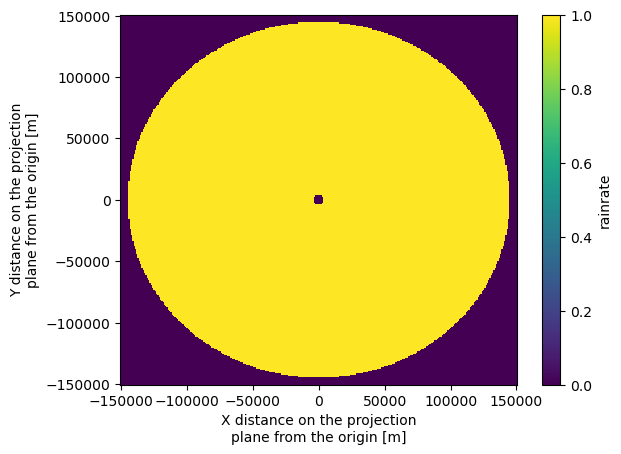

In [40]:
masked_ds = ds_radar_W.rainrate.mean(dim='time')#.count().sum().values
mask = ~masked_ds.isnull()
mask.plot()

In [6]:
%%time
mask_qualityW = ds_radar_W.isfile[ds_radar_W.isfile.values>0]
masked_qualityW = ds_radar_W.rainrate.where(mask_qualityW)

CPU times: user 141 ms, sys: 15.6 ms, total: 157 ms
Wall time: 194 ms


In [11]:
def freq(ds,masked_ds,willis=None):
    if willis==True:
        mask = ds.mean(dim='time')
        mask = ~mask.isnull()
        masked = ds.where(mask)
        valid_dps = masked.mean(dim='time').count().sum().values
        print('Valid data points after masking corners and cone of silence: ',valid_dps)
        hourly_rr = masked.groupby(masked.time.dt.hour)
        rr_sum = []
        for hour in np.arange(0,24,1):
            # if hour==5:
            #     pass
            # elif hour==6:
            #     pass
            # elif hour==11:
            #     pass
            # elif hour==12:
            #     pass
            # else:
            ds_mask = hourly_rr[hour]#.sel(time=~invalid_window)
            valid_times = len(ds_mask) # length of times, ds_mask.time.count().sum().values
            print('Hour: ',hour,', Length of valid time data points: ',valid_times)
            total_valid_dps = valid_dps*valid_times
            raining_dps = ds_mask.count().sum().values 
            print('Total valid data points: ',total_valid_dps,', Raining data points: ',raining_dps)
            percentage_rain = (raining_dps/total_valid_dps)*100
            rr_sum.append(percentage_rain)
    else:
        masked_ds.persist()
        mask = ~masked_ds.isnull() #~ inverts the mask to set nan as False
        mask.persist()
        masked = ds.rainrate.where(mask)
        valid_dps = masked.mean(dim='time').count().sum().values
        
        hourly_rr = masked.groupby(masked.time.dt.hour) # group times of masked ds by hour
        rr_sum = []
        for hour in np.arange(0,24,1):
            len_times = len(hourly_rr[hour])
            print('Length of time points: ',len_times)
            total_valid_dps = valid_dps*len_times
            raining_dps = hourly_rr[hour].count().sum().values 
            print('Total valid data points: ',total_valid_dps,', Raining data points: ',raining_dps)
            percentage_rain = (raining_dps/total_valid_dps)*100
            rr_sum.append(percentage_rain)
    return rr_sum

# Rainrate frequency - wind composites

In [23]:
def generate_diurnal_ds(ds,masked_ds,wind_dir,wind_dir1,wind_dir2,willis=None):
    # select wind directions
    wind = wind_dir[(wind_dir>wind_dir1*units("degree"))&(wind_dir<wind_dir2*units("degree"))]
    
    # select wind time values
    wind_times = wind.time.values
    wind_times.sort() 
    print('Length of wind time points for wind directions between ',wind_dir1,' and ',wind_dir2,': ',len(wind_times))
    
    # Define the time window of 30 minutes - to select radar data +30/-30min of selected BARRA2 wind direction hour
    window_size = pd.Timedelta(minutes=30)
    
    # Initialize empty list to store selected data
    selected_data = []
    
    # Loop through each time point in wind (directions chosen above); or for deep easterlies, through: wind_speed_SE_10ms
    # mask = ds.rainrate.where(masked_ds)
    data = masked_ds
    for time in wind['time']: 
        # Calculate the start and end times of the window
        window_start = time - window_size
        window_end = time + window_size
        # Select the data within the time window from ds2 using slice
        # data_within_window = ds.rainrate.sel(time=slice(window_start, window_end))
        data_within_window = data.sel(time=slice(window_start, window_end))
        # Append the selected data to the list
        selected_data.append(data_within_window)
        
    # Concatenate the selected data into a single xarray dataset
    radar_composite_winds = xr.concat(selected_data, dim='time')

    if willis==True:
        print('Length of radar composite wind times: ',len(radar_composite_winds))
        mask = ds.mean(dim='time')
        mask = ~mask.isnull()
        masked = radar_composite_winds.where(mask)
        valid_dps = masked.mean(dim='time').count().sum().values
        print('Sum of valid datapoints: ',valid_dps)
        hourly_rr = masked.groupby(masked.time.dt.hour)
        diurnal_rr_frq = []
        for hour in np.arange(0,24,1):
            # if hour==5:
            #     diurnal_rr_frq.append(np.nan)
            # elif hour==6:
            #     diurnal_rr_frq.append(np.nan)
            # elif hour==11:
            #     diurnal_rr_frq.append(np.nan)
            # elif hour==12:
            #     diurnal_rr_frq.append(np.nan)
            # else:
            ds_mask = hourly_rr[hour]#.sel(time=~invalid_window)
            valid_times = len(ds_mask) # length of times, ds_mask.time.count().sum().values
            print('Hour: ',hour,', Length of valid time data points: ',valid_times)
            total_valid_dps = valid_dps*valid_times
            raining_dps = ds_mask.count().sum().values 
            print('Total valid data points: ',total_valid_dps,', Raining data points: ',raining_dps)
            percentage_rain = (raining_dps/total_valid_dps)*100
            diurnal_rr_frq.append(percentage_rain)
    else:
        masked_ds.persist()
        mask = ~masked_ds.isnull() #~ inverts the mask to set nan as False
        mask.persist()
        masked = radar_composite_winds.where(mask)
        valid_dps = masked.mean(dim='time').count().sum().values
        hourly_rr = masked.groupby(masked.time.dt.hour)
        diurnal_rr_frq = []
        for hour in np.arange(0,24,1):
            len_times = len(hourly_rr[hour])
            print('Length of time points: ',len_times)
            total_valid_dps = valid_dps*len_times
            raining_dps = hourly_rr[hour].count().sum().values 
            print('Total valid data points: ',total_valid_dps,', Raining data points: ',raining_dps)
            percentage_rain = (raining_dps/total_valid_dps)*100
            diurnal_rr_frq.append(percentage_rain)
    return diurnal_rr_frq

In [24]:
willis_SE = generate_diurnal_ds(masked_qualityW,masked_qualityW,wind_dir_towns,90,180)

Length of wind time points for wind directions between  90  and  180 :  17567


ValueError: cannot reindex or align along dimension 'time' because the (pandas) index has duplicate values

In [ ]:
willis_NE = generate_diurnal_ds(ds_radar_W,wind_dir_towns,0,90)
willis_SW = generate_diurnal_ds(ds_radar_W,wind_dir_towns,180,270)
willis_NW = generate_diurnal_ds(ds_radar_W,wind_dir_towns,270,360)

In [67]:
willis_SE_nans = [3.116741241437937,3.3470850378570476,3.7472037331760064,4.187756908225547,4.5120669389611265,np.nan,np.nan,4.607443985318834,4.7372261172719545,4.83928365065141,4.923416904335129,np.nan,np.nan,
             5.270108382887364,5.5478632689759575,5.675199401221834,5.656971771441518,5.582523445026421,5.484139315371306,5.285854897261282,5.076579990588833,4.5937749781168185,3.996704532170358,3.2951479926131406]

(0.0, 20.0)

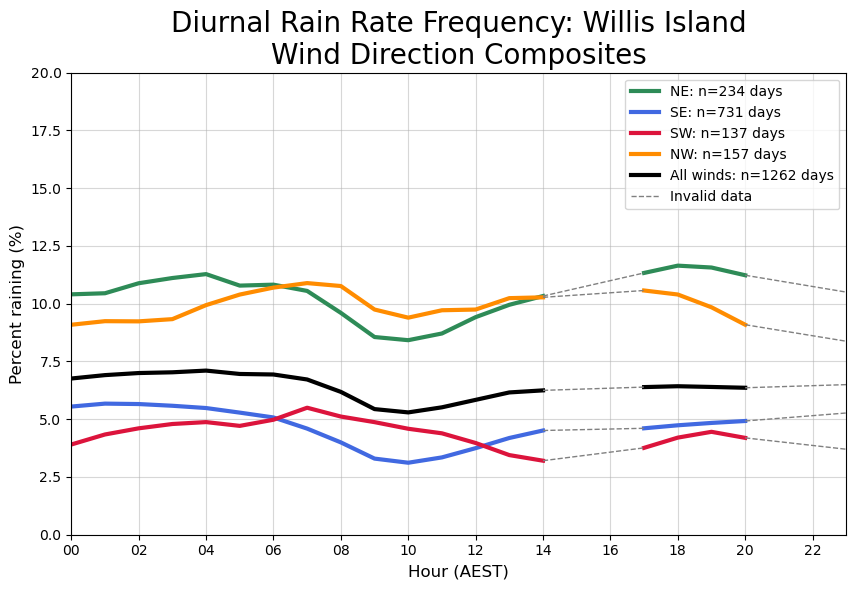

In [102]:
# plot diurnal rainrate frequency wind composites:
rr_SE_willis = np.roll(willis_SE_nans, shift=10)
rr_NE_willis = np.roll(willis_NE, shift=10)
rr_NW_willis = np.roll(willis_NW, shift=10)
rr_SW_willis = np.roll(willis_SW, shift=10)

fig = plt.figure(1, figsize=[10,6])
fig.patch.set_facecolor('white')
ax = plt.subplot(1, 1, 1)
ax.plot(np.arange(0,24,1),rr_NE_willis,linewidth=3,color="seagreen", linestyle='-',label='NE: n=234 days')
ax.plot(np.arange(0,24,1),rr_SE_willis,linewidth=3,color="royalblue", linestyle='-',label='SE: n=731 days')
ax.plot(np.arange(0,24,1),rr_SW_willis,linewidth=3,color="crimson", linestyle='-',label='SW: n=137 days')
ax.plot(np.arange(0,24,1),rr_NW_willis,linewidth=3,color="darkorange", linestyle='-',label='NW: n=157 days')
ax.plot(np.arange(0,24,1),willis_raining,linewidth=3,color="black", linestyle='-',label='All winds: n=1262 days')

plt.plot(np.arange(0,24,1)[valid_indices[14:16]], np.array(rr_SE_willis)[valid_indices[14:16]], linestyle='--',linewidth=1,color="grey",label='Invalid data')
plt.plot(np.arange(0,24,1)[valid_indices[18:22]], np.array(rr_SE_willis)[valid_indices[18:22]], linestyle='--',linewidth=1,color="grey")
plt.plot(np.arange(0,24,1)[valid_indices[14:16]], np.array(rr_NE_willis)[valid_indices[14:16]], linestyle='--',linewidth=1,color="grey")
plt.plot(np.arange(0,24,1)[valid_indices[18:22]], np.array(rr_NE_willis)[valid_indices[18:22]], linestyle='--',linewidth=1,color="grey")
plt.plot(np.arange(0,24,1)[valid_indices[14:16]], np.array(rr_NW_willis)[valid_indices[14:16]], linestyle='--',linewidth=1,color="grey")
plt.plot(np.arange(0,24,1)[valid_indices[18:22]], np.array(rr_NW_willis)[valid_indices[18:22]], linestyle='--',linewidth=1,color="grey")
plt.plot(np.arange(0,24,1)[valid_indices[14:16]], np.array(rr_SW_willis)[valid_indices[14:16]], linestyle='--',linewidth=1,color="grey")
plt.plot(np.arange(0,24,1)[valid_indices[18:22]], np.array(rr_SW_willis)[valid_indices[18:22]], linestyle='--',linewidth=1,color="grey")
plt.plot(np.arange(0,24,1)[valid_indices[14:16]], np.array(willis_raining)[valid_indices[14:16]], linestyle='--',linewidth=1,color="grey")
plt.plot(np.arange(0,24,1)[valid_indices[18:22]], np.array(willis_raining)[valid_indices[18:22]], linestyle='--',linewidth=1,color="grey")

ax.set_xlim(0,23)
plt.legend()
ax.set_title('Diurnal Rain Rate Frequency: Willis Island\nWind Direction Composites',fontsize=20)
ax.set_xlabel("Hour (AEST)",fontsize=12)
ax.set_ylabel("Percent raining (%)",fontsize=12)
ax.set_xticks(np.arange(0,24,2))
ax.set_xticklabels(["00","02","04","06","08","10","12","14","16","18","20","22"])
ax.grid(alpha=0.5)
ax.set_ylim(0,20)
# ax.annotate('n = 1,262 days',(19,1))

# willis island investigation

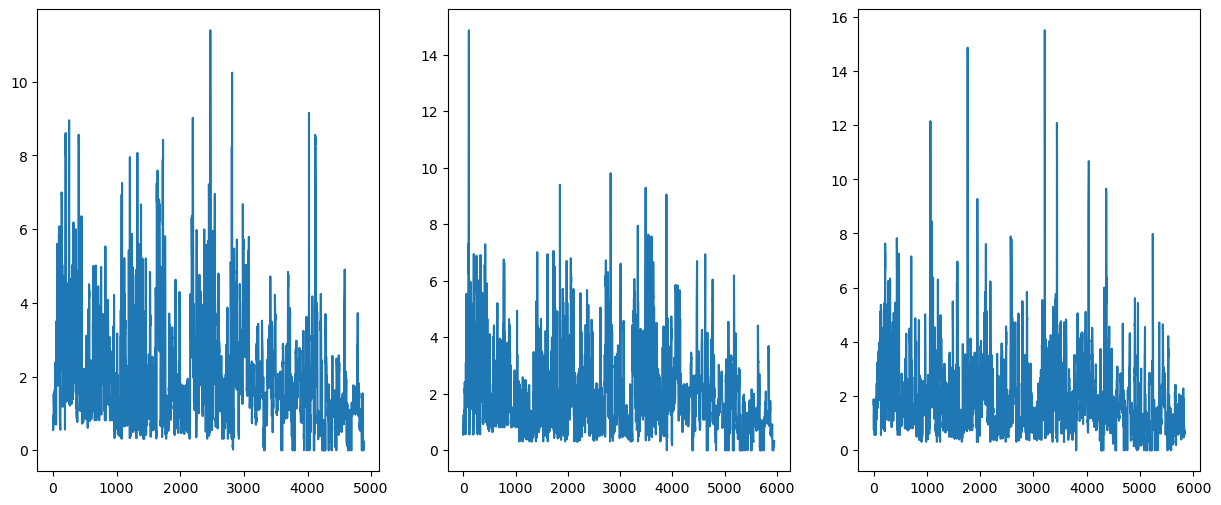

In [24]:
fig,ax = plt.subplots(1,3, figsize=[15,6])
fig.patch.set_facecolor('white')
data = ds_radar_W.rainrate
valid_dps = ds_radar_W.rainrate.mean(dim='time')
mask = ~valid_dps.isnull()
masked = data.where(mask)
hourly_rr = masked.groupby(masked.time.dt.hour) # group times of masked ds by hour
rr_5 = hourly_rr[5]
rr_6 = hourly_rr[6]
rr_11 = hourly_rr[11]

invalid_points5 = hourly_rr[5].mean(dim=['x','y']).isnull()
invalid_points6 = hourly_rr[6].mean(dim=['x','y']).isnull()
invalid_points11 = hourly_rr[11].mean(dim=['x','y']).isnull()
invalid_points11 = hourly_rr[12].mean(dim=['x','y']).isnull()

invalid_window5 = invalid_points5.rolling(time=1, min_periods=1).sum() == 1
dataset_filtered5 = rr_5.sel(time=~invalid_window5)
invalid_window6 = invalid_points6.rolling(time=1, min_periods=1).sum() == 1
dataset_filtered6 = rr_6.sel(time=~invalid_window6)
invalid_window11 = invalid_points11.rolling(time=1, min_periods=1).sum() == 1
dataset_filtered11 = rr_11.sel(time=~invalid_window11)
invalid_window12 = invalid_points12.rolling(time=1, min_periods=1).sum() == 1
dataset_filtered12 = rr_11.sel(time=~invalid_window12)

ax[0].plot(dataset_filtered5.mean(dim=['x','y']))
ax[1].plot(dataset_filtered6.mean(dim=['x','y']))
ax[2].plot(dataset_filtered11.mean(dim=['x','y']))

CPU times: user 15min 48s, sys: 4min 20s, total: 20min 8s
Wall time: 1min 21s


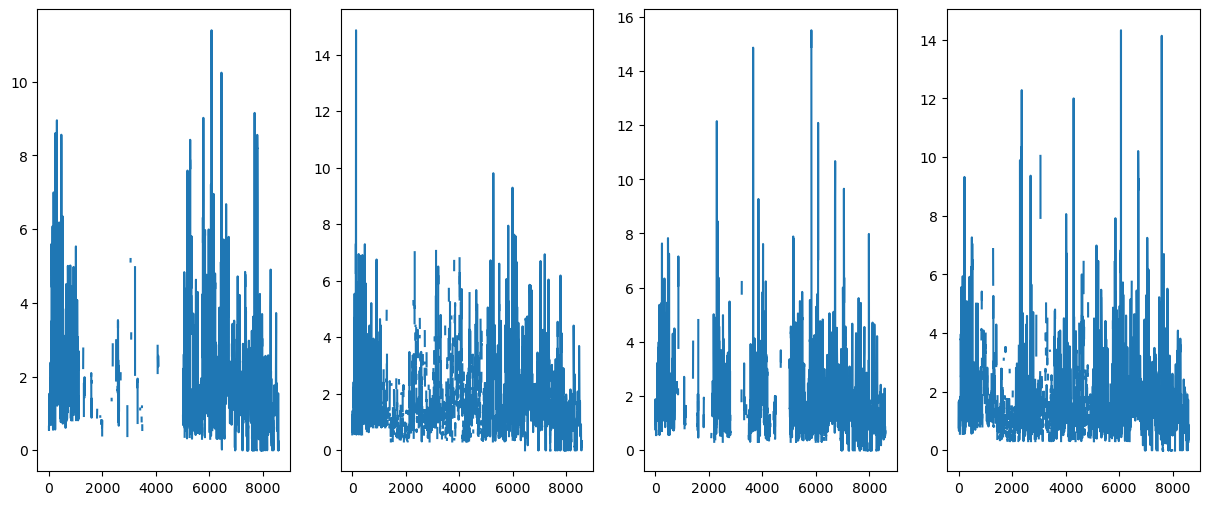

In [104]:
%%time
fig,ax = plt.subplots(1,4, figsize=[15,6])
fig.patch.set_facecolor('white')
valid_dps = ds_radar_W.rainrate.mean(dim='time')
mask = ~valid_dps.isnull()
masked = ds_radar_W.rainrate.where(mask)
hourly_rr = masked.groupby(masked.time.dt.hour) # group times of masked ds by hour
ax[0].plot(hourly_rr[5].mean(dim=['x','y']))
ax[1].plot(hourly_rr[6].mean(dim=['x','y']))
ax[2].plot(hourly_rr[11].mean(dim=['x','y']))
ax[3].plot(hourly_rr[12].mean(dim=['x','y']))

CPU times: user 15min 37s, sys: 4min 16s, total: 19min 53s
Wall time: 1min 20s


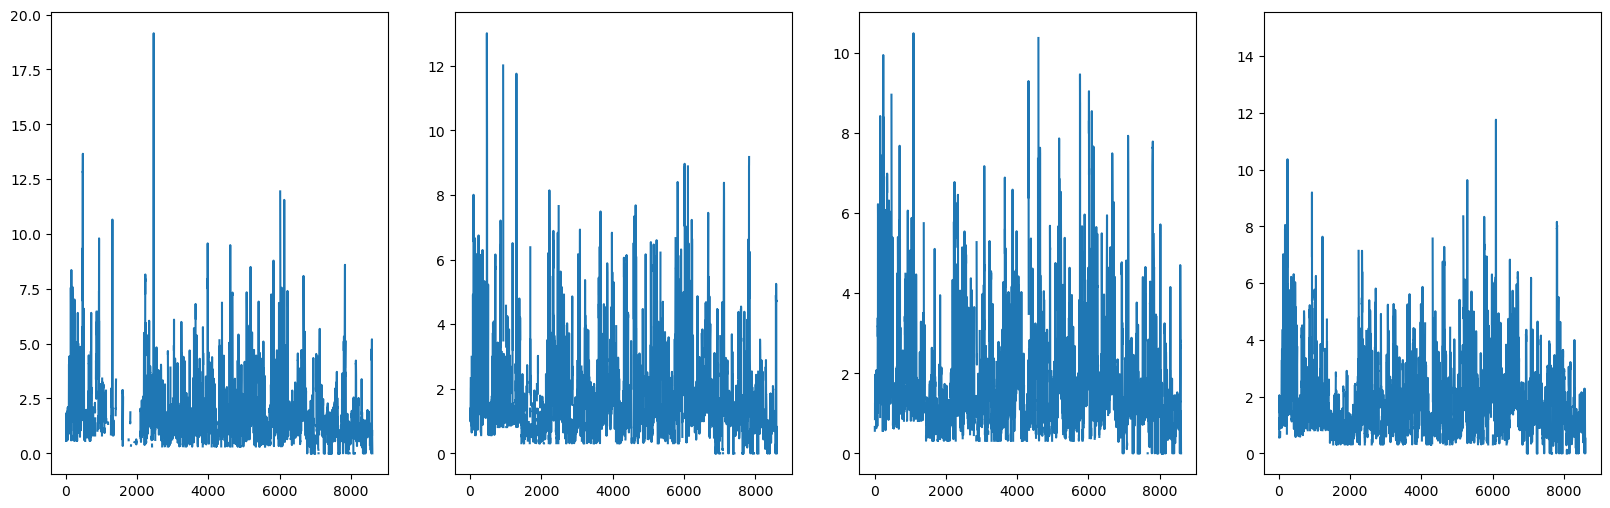

In [106]:
%%time
fig,ax = plt.subplots(1,4, figsize=[20,6])
fig.patch.set_facecolor('white')
valid_dps = ds_radar_W.rainrate.mean(dim='time')
mask = ~valid_dps.isnull()
masked = ds_radar_W.rainrate.where(mask)
hourly_rr = masked.groupby(masked.time.dt.hour) # group times of masked ds by hour
ax[0].plot(hourly_rr[0].mean(dim=['x','y']))
ax[1].plot(hourly_rr[1].mean(dim=['x','y']))
ax[2].plot(hourly_rr[2].mean(dim=['x','y']))
ax[3].plot(hourly_rr[3].mean(dim=['x','y']))

In [130]:
# plt.scatter(ds_radar_W.isfile.values,len(ds_radar_W.isfile.values))

mask = ds_radar_W.isfile[ds_radar_W.isfile.values>0]
masked = ds_radar_W.rainrate.where(mask)
# masked.plot()

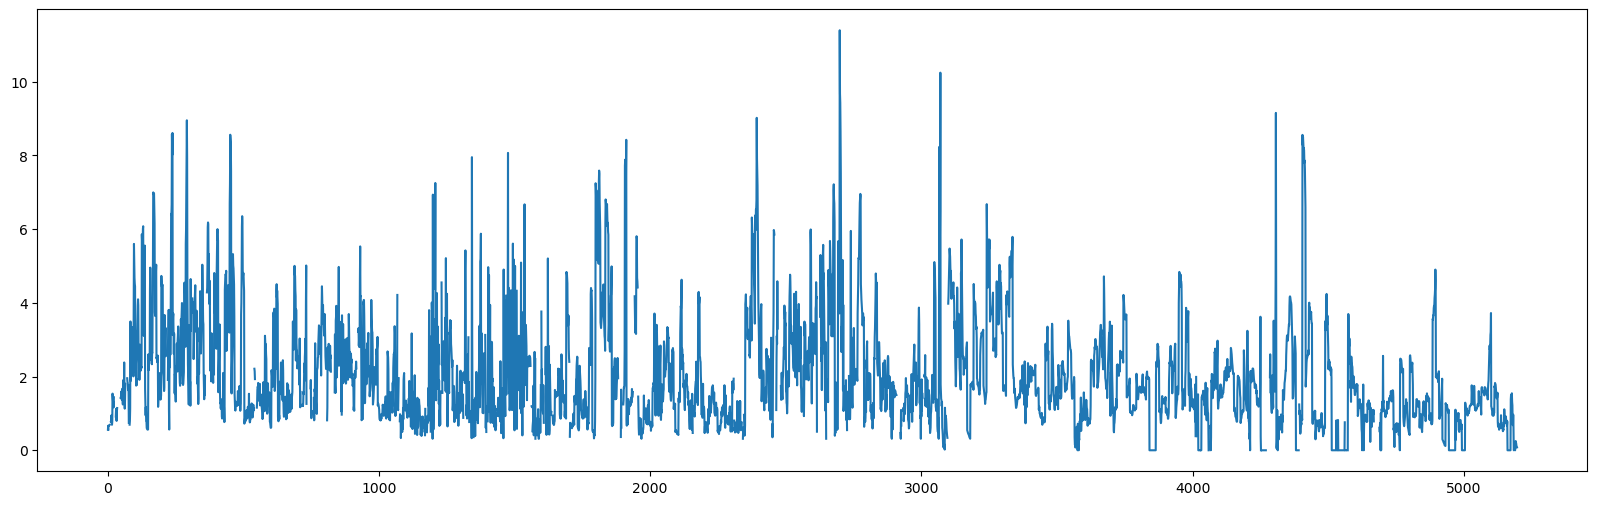

In [132]:
fig,ax = plt.subplots(1,1, figsize=[20,6])
fig.patch.set_facecolor('white')
hourly_rr = masked.groupby(masked.time.dt.hour) # group times of masked ds by hour
ax.plot(hourly_rr[5].mean(dim=['x','y']))

# back to frequency

In [12]:
%%time
# towns_land_frq = freq(ds_radar_T,land_towns,willis=False)
# towns_ocean_frq = freq(ds_radar_T,ocean_towns,willis=False)
# # cairns_land_frq = freq(ds_radar_C,land_cairns,willis=False)
# cairns_ocean_frq = freq(ds_radar_C,ocean_cairns,willis=False)
willis_percent = freq(masked_qualityW,ds_radar_W,willis=True)

Valid data points after masking corners and cone of silence:  65836
Hour:  0 , Length of valid time data points:  7483
Total valid data points:  492650788 , Raining data points:  29973504
Hour:  1 , Length of valid time data points:  8174
Total valid data points:  538143464 , Raining data points:  31220239
Hour:  2 , Length of valid time data points:  8420
Total valid data points:  554339120 , Raining data points:  33045982
Hour:  3 , Length of valid time data points:  8456
Total valid data points:  556709216 , Raining data points:  34867297
Hour:  4 , Length of valid time data points:  8429
Total valid data points:  554931644 , Raining data points:  35372228
Hour:  5 , Length of valid time data points:  5197
Total valid data points:  342149692 , Raining data points:  24443214
Hour:  6 , Length of valid time data points:  6417
Total valid data points:  422469612 , Raining data points:  29206787
Hour:  7 , Length of valid time data points:  8426
Total valid data points:  554734136 , Rai

(0.0, 15.0)

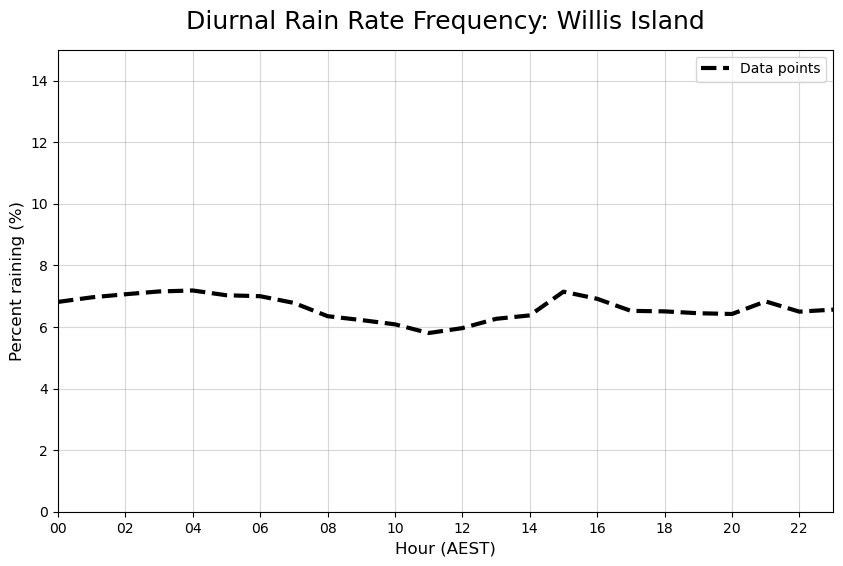

In [13]:
# townsland = np.roll(towns_land_frq, shift=10)
# townsocean = np.roll(towns_ocean_frq, shift=10)
# cairnsland = np.roll(cairns_land_frq, shift=10)
# cairnsocean = np.roll(cairns_ocean_frq, shift=10)
# willisocean = np.roll(willis_frq, shift=10)
willis_raining = np.roll(willis_percent, shift=10)
# valid_indices = np.where(~np.isnan(willis_raining))[0]

fig = plt.figure(1, figsize=[10,6])
fig.patch.set_facecolor('white')
ax = plt.subplot(1, 1, 1)
# ax.plot(np.arange(0,24,1),willis_raining,linewidth=3,color="black")#,label='Coastal Land')
ax.plot(np.arange(0,24,1),willis_raining,linewidth=3,color="black",linestyle='--',label='Data points')
# connect where nans are
# plt.plot(np.arange(0,24,1)[valid_indices[14:16]], np.array(willis_raining)[valid_indices[14:16]], linestyle='--',linewidth=3,color="grey",label='Invalid data')
# plt.plot(np.arange(0,24,1)[valid_indices[18:22]], np.array(willis_raining)[valid_indices[18:22]], linestyle='--',linewidth=3,color="grey")
ax.set_xlim(0,23)
plt.legend()
ax.set_title("Diurnal Rain Rate Frequency: Willis Island",fontsize=18,pad=15)
ax.set_xlabel("Hour (AEST)",fontsize=12)
ax.set_ylabel("Percent raining (%)",fontsize=12)
ax.set_xticks(np.arange(0,24,2))
ax.set_xticklabels(["00","02","04","06","08","10","12","14","16","18","20","22"])
ax.grid(alpha=0.5)
ax.set_ylim(0,15)
# ax.annotate('n = 1,262 days',(19,1)) # where n = time data points per hour grouped (11,012*24=total time data points) 

# Plot composite contour plots for rainrate (based on BARRA2 wind regimes)

In [ ]:
def plot_mean_rr(ds_radar,wind_dir1,wind_dir2,threshold,mask_threshold,annx,anny,lon1,lon2,lat1,lat2,xticks,xticklabels,yticks,yticklabels,cmapcb,cmap,vmax,title):
    radar_mean = ds_radar.rainrate.isel(x=slice(0,300),y=slice(0,300)).mean(dim="time")
    # create masked data by setting a climatological threshold 
    masked_ds = xr.where((radar_mean < threshold), np.nan, radar_mean)
    # define wind directions
    winds = wind_dir[(wind_dir>wind_dir1*units("degree"))&(wind_dir<wind_dir2*units("degree"))]
    # extract wind time values
    wind_times = winds.time.values
    wind_times.sort() 
    # select radar data times which closest equal to wind direction times
    mean_rr = ds_radar.isel(x=slice(0,300),y=slice(0,300)).rainrate.sel(time=wind_times,method="nearest").mean(dim=["time"]) 
    # mask data
    masked_data = xr.where((radar_mean < threshold), np.nan,mean_rr)
    # plot
    fig = plt.figure(1, figsize=[10,6])
    fig.patch.set_facecolor('white')
    ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
    sel_lat_lon = ds_bath["z"].sel(x=slice(lon1,lon2),y=slice(lat1,lat2))
    cmapc = plt.get_cmap(cmapcb)
    sel_lat_lon.plot.contour(levels=7,ax=ax, cmap=cmapc,alpha=1,vmin=0)
    ax.annotate(mask_threshold,(annx,anny),fontsize=10)
    ax.set_xlim(lon1,lon2) 
    ax.set_ylim(lat1,lat2)  
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlabel("Longitude")
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_ylabel("Latitude")
    ax.set_title(title,fontsize=15)
    # plot mean rain rate for each x, y across all easterly times
    norm = mcolors.Normalize(vmin=0, vmax=vmax)  # Normalize the cb data
    cmapcf = plt.get_cmap(cmap)
    cf = ax.contourf(ds_radar.longitude.isel(time=0,x=slice(0,294),y=slice(0,294)),ds_radar.latitude.isel(time=0,x=slice(0,294),y=slice(0,294)),
                     masked_data.isel(x=slice(0,294),y=slice(0,294)),levels=50,vmin=0,vmax=vmax,cmap=cmapcf,alpha=1,norm=norm)
    cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmapcf))
    cb.set_label('Rain rate (mm/h)')
    plt.tight_layout()
    return

In [ ]:
# Cairns: (ds_radar,wind_dir1,wind_dir2,threshold1,threshold2,mask_threshold,annx,anny,lon1,lon2,lat1,lat2,xticks,xticklabels,yticks,yticklabels,cmapcb,cmap,vmax,title)

# westerlies
# plot_mean_rr(ds_radar_C,180,360,1.5,"Mask: < 1.5",146.5,-15.4,144,147.5,-18.5,-15.25,[144,144.5,145,145.5,146,146.5,147,147.5],
#             ["144","144.5","145","145.5","146","146.5","147","147.5"],[-18.5,-18,-17.5,-17,-16.5,-16,-15.5],
#             ["-18.5","-18","-17.5","-17","-16.5","-16","-15.5"],"binary","jet",5,"Masked mean Cairns rainrate 2012-2022: Westerly wind components")
# NEs     
# plot_mean_rr(ds_radar_C,0,90,1.5,"Mask: < 1.5",146.5,-15.4,144,147.5,-18.5,-15.25,[144,144.5,145,145.5,146,146.5,147,147.5],["144","144.5","145","145.5","146","146.5","147","147.5"],
#             [-18.5,-18,-17.5,-17,-16.5,-16,-15.5],
#             ["-18.5","-18","-17.5","-17","-16.5","-16","-15.5"],"binary","jet",5,"Masked mean Cairns rainrate 2012-2022: NE wind components (0-90)")
# SEs
# plot_mean_rr(ds_radar_C,90,180,1.5,"Mask: < 1.5",146.75,-15.4,144,147.5,-18.5,-15.25,[144,144.5,145,145.5,146,146.5,147,147.5],["144","144.5","145","145.5","146","146.5","147","147.5"],
#              [-18.5,-18,-17.5,-17,-16.5,-16,-15.5],
#              ["-18.5","-18","-17.5","-17","-16.5","-16","-15.5"],"binary","jet",5,"Masked mean Cairns rainrate 2012-2022: SE wind components (90-180)") 
            # .isel(x=slice(0,294),y=slice(0,294)): for SE there is a weird piece in the data, this means it won't be plotted

# Diurnal plots - Intensity

In [9]:
def generate_diurnal_ds_no_winds(masked_ds,ds,coastal=None):
    hourly_grouped_rr = ds.rainrate.groupby(ds.time.dt.hour)
    diurnal_rr_all = []
    if coastal==True:
        masked_ds.persist()
        mask = ~masked_ds.isnull() #~ inverts the mask to set nan as False
        mask.persist()
        masked = ds.rainrate.where(mask)
        hourly_grouped_rr = masked.groupby(masked.time.dt.hour)
        for hours in np.arange(0,24,1):
            rr_mean = hourly_grouped_rr[hours].mean(dim=["time",'x','y'],skipna=True) 
        # mask T and C to remove errors from beam blockage & separate land vs coastal ocean
            # masked_data = xr.where(np.isnan(hourly_grouped_rr[hours]), np.nan,rr_mean)
            # mean = masked_data.mean(dim=["x","y"])
            print(hours)
            diurnal_rr_all.append(rr_mean.values)
    else:
        for hours in np.arange(0,24,1):
            rr_mean = hourly_grouped_rr[hours].mean(dim=["time",'x','y'],skipna=True) 
            print(hours)
            diurnal_rr_all.append(rr_mean.values) 
    return diurnal_rr_all

In [10]:
%%time 
# frequency of all times (no wind composites)
# rainrate_land_T = generate_diurnal_ds_no_winds(land_towns,ds_radar_T,coastal=True)
# rainrate_ocean_T = generate_diurnal_ds_no_winds(ocean_towns,ds_radar_T,coastal=True)

rainrate_land_C = generate_diurnal_ds_no_winds(land_cairns,ds_radar_C,coastal=True)
rainrate_ocean_C = generate_diurnal_ds_no_winds(ocean_cairns,ds_radar_C,coastal=True)
# rainrate_W = generate_diurnal_ds_no_winds(ds_radar_W,masked_qualityW,coastal=False) # doesn't matter which mask input

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
CPU times: user 3h 56min 44s, sys: 1h 20min 50s, total: 5h 17min 35s
Wall time: 21min 7s


In [13]:
rr_ocean_T

array([2.353462 , 2.391276 , 2.4124808, 2.3214912, 2.2316918, 2.1573987,
       2.0852263, 1.967367 , 1.9296213, 1.9646109, 1.9945257, 2.0125716,
       1.952079 , 1.8638947, 1.8189062, 1.9019389, 1.9513342, 2.0640821,
       2.103818 , 2.0700092, 2.1069145, 2.2012556, 2.2468367, 2.3191667],
      dtype=float32)

(0.0, 3.0)

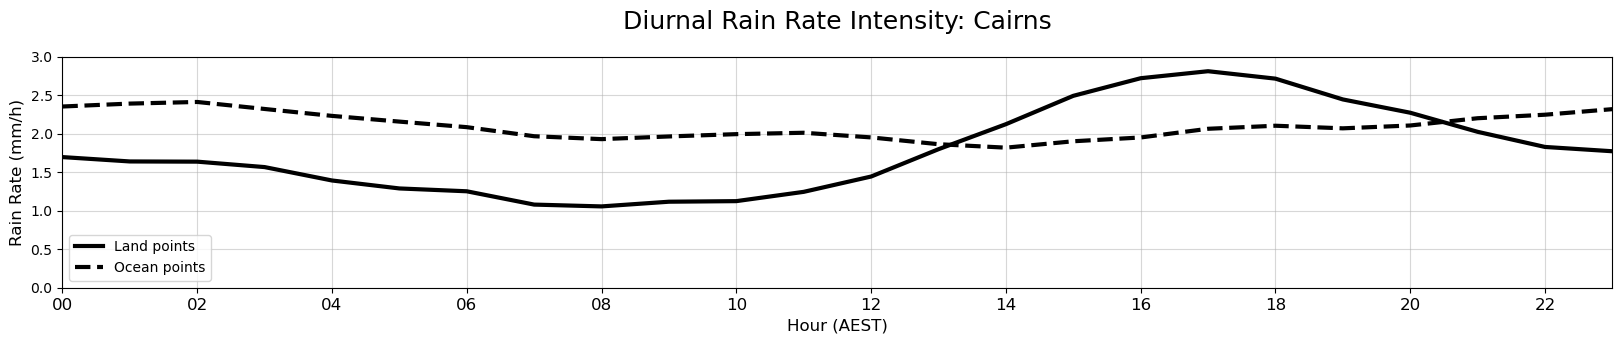

In [11]:
rr_land_T = np.roll(rainrate_land_C, shift=10)
rr_ocean_T = np.roll(rainrate_ocean_C,shift=10)

fig = plt.figure(1, figsize=[20,3])
fig.patch.set_facecolor('white')
ax = plt.subplot(1, 1, 1)
ax.plot(np.arange(0,24,1),rr_land_T,linewidth=3,color="black",label='Land points')
ax.plot(np.arange(0,24,1),rr_ocean_T,linewidth=3,color="black",linestyle='--',label='Ocean points')
ax.set_xlim(0,23)
plt.legend()
ax.set_title("Diurnal Rain Rate Intensity: Cairns",fontsize=18,pad=20)
ax.set_xlabel("Hour (AEST)",fontsize=12)
ax.set_ylabel("Rain Rate (mm/h)",fontsize=12)
ax.set_xticks(np.arange(0,24,2))
ax.set_xticklabels(["00","02","04","06","08","10","12","14","16","18","20","22"],fontsize=12)
ax.grid(alpha=0.5)
ax.set_ylim(0,3)
# ax.annotate('n = 1,262 days',(19,1))

In [33]:
radar_mean = ds_radar_T.rainrate.mean(dim=["time"],skipna=True)
masked_beam_blockage = xr.where((radar_mean < 1), np.nan,radar_mean) # threshold for Townsville: 1mm/h rain rate mean
bathymetry = ds_bath["z"].sel(x=ds_radar_T.longitude.isel(time=0),y=ds_radar_T.latitude.isel(time=0),method="nearest").drop("time")
# bathymetry_mask = bathymetry <= 0 # masks ocean - only looking at land areas
bathymetry_mask = bathymetry > 0 # masks land surface - only looking at ocean areas

# create land/ocean mask
masked_radar_data = xr.where(bathymetry_mask, np.nan, masked_beam_blockage) # townsville
# masked_radar_data = xr.where(bathymetry_mask, np.nan, masked_beam_blockagev2) #cairns

def generate_diurnal_ds(ds,wind_dir,wind_dir1,wind_dir2):
    # mean precip 
    # radar_mean = masked_radar_data # T&C
    # radar_mean.persist()
    
    # select wind directions
    wind = wind_dir[(wind_dir>wind_dir1*units("degree"))&(wind_dir<wind_dir2*units("degree"))]
    
    # select wind time values
    wind_times = wind.time.values
    wind_times.sort() 
    
    # Define the time window of 30 minutes - to select radar data +30/-30min of selected BARRA2 wind direction hour
    window_size = pd.Timedelta(minutes=30)
    # Initialize empty list to store selected data
    selected_data = []
    # Loop through each time point in wind (directions chosen above); or for deep easterlies, through: wind_speed_SE_10ms
    for time in wind['time']: #wind['time']
        # Calculate the start and end times of the window
        window_start = time - window_size
        window_end = time + window_size
        # Select the data within the time window from ds2 using slice
        data_within_window = ds.rainrate.sel(time=slice(window_start, window_end))
        # print('Radar data points for deep SE: ',len(data_within_window))
        # print('Radar data points nan: ',np.sum(np.isnan(data_within_window)).values)
        # print('Radar min value: ',data_within_window.min().values)
        # Append the selected data to the list
        selected_data.append(data_within_window)
    # Concatenate the selected data into a single xarray dataset
    radar_composite_winds = xr.concat(selected_data, dim='time')
    
    # select radar data times which closest equal to wind times - original method which only considers radar data (10min intervals) closest to the hourly wind BARRA2 data
    hourly_grouped_rr = radar_composite_winds.groupby(radar_composite_winds.time.dt.hour)
    
    diurnal_rr = []
    for hours in np.arange(0,24,1):
        print(hours)
        rr_mean = hourly_grouped_rr[hours].mean(dim=["time"],skipna=True) # townsville, cairns: dim=["time"]; willis ['time','x','y']
        masked_data = xr.where(np.isnan(masked_radar_data), np.nan,rr_mean)
        mean = masked_data.mean(dim=["x","y"])
        diurnal_rr.append(mean.values) # townsville, cairns: mean.values; willis: rr_mean
    return diurnal_rr

In [32]:
%%time
# generate grouped arrays for wind direction composite data
south_westerlies_rr = generate_diurnal_ds(ds_radar_T,wind_dir_towns,180,270)
north_westerlies_rr = generate_diurnal_ds(ds_radar_T,wind_dir_towns,270,360)
north_easterlies_rr = generate_diurnal_ds(ds_radar_T,wind_dir_towns,0,90)
south_easterlies_rr = generate_diurnal_ds(ds_radar_T,wind_dir_towns,90,180)
# south_easterlies_rr_deepE = generate_diurnal_ds(ds_radar_T,90,180)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
CPU times: user 4h 18min 1s, sys: 52min 42s, total: 5h 10min 44s
Wall time: 23min 3s


In [34]:
# generate grouped arrays for wind direction composite data - ocean areas
south_westerlies_rr_seas = generate_diurnal_ds(ds_radar_T,wind_dir_towns,180,270)
north_westerlies_rr_seas = generate_diurnal_ds(ds_radar_T,wind_dir_towns,270,360)
north_easterlies_rr_seas = generate_diurnal_ds(ds_radar_T,wind_dir_towns,0,90)
south_easterlies_rr_seas = generate_diurnal_ds(ds_radar_T,wind_dir_towns,90,180)
# south_easterlies_rr_seas_deepE = generate_diurnal_ds(ds_radar_C,90,180)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [35]:
# shift arrays so that first item is for time 00 AEST 
south_westerlies = np.roll(south_westerlies_rr, shift=10)
north_westerlies = np.roll(north_westerlies_rr, shift=10)
north_easterlies = np.roll(north_easterlies_rr, shift=10)
south_easterlies = np.roll(south_easterlies_rr, shift=10)
# rainrate_all = np.roll(rainrate_grouped, shift=10)
south_westerlies_seas = np.roll(south_westerlies_rr_seas, shift=10)
north_westerlies_seas = np.roll(north_westerlies_rr_seas, shift=10)
north_easterlies_seas = np.roll(north_easterlies_rr_seas, shift=10)
south_easterlies_seas = np.roll(south_easterlies_rr_seas, shift=10)
# rainrate_all_seas = np.roll(rainrate_grouped_C_seas, shift=10)

# south_easterlies_deepE = np.roll(south_easterlies_rr_deepE, shift=10)
# south_easterlies_seas_deepE = np.roll(south_easterlies_rr_seas_deepE, shift=10)
# south_easterlies_deepE12 = np.roll(south_easterlies_rr_deepE, shift=10)
# south_easterlies_seas_deepE12 = np.roll(south_easterlies_rr_seas_deepE, shift=10)
# south_easterlies_deepEbetween = np.roll(south_easterlies_rr_deepE, shift=10)
# south_easterlies_seas_deepEbetween = np.roll(south_easterlies_rr_seas_deepE, shift=10)

In [77]:
south_easterlies_seas

array([1.4877396, 1.4447372, 1.5196564, 1.5067604, 1.5662042, 1.5457934,
       1.4811423, 1.3855389, 1.3586911, 1.3805655, 1.3603928, 1.3503668,
       1.2942144, 1.293137 , 1.2706414, 1.231505 , 1.1510315, 1.1591402,
       1.2052368, 1.1276575, 1.1521173, 1.2614595, 1.3397148, 1.3990343],
      dtype=float32)

In [68]:
winds = wind_dir_towns[(wind_dir_towns>270*units("degree"))&(wind_dir_towns<=360*units("degree"))]
len(winds)

1799

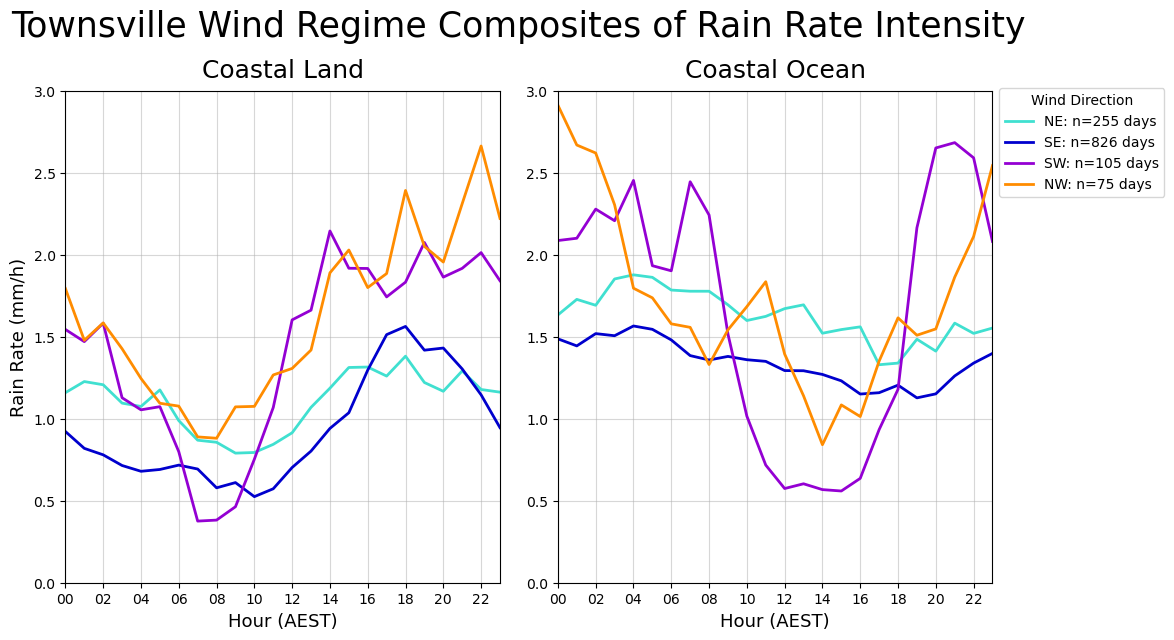

In [97]:
UTC = np.arange(0,24,1) #["00","03","06","09","12","15","18","21"]

fig,ax = plt.subplots(1,2, figsize=[10,6])
fig.patch.set_facecolor('white')
fig.suptitle('Townsville Wind Regime Composites of Rain Rate Intensity',y=1.02,fontsize=25)
fig.tight_layout()
# plot land:
ax[0].plot(UTC,north_easterlies,color="turquoise",linewidth=2,label='NE',)
ax[0].plot(UTC,south_easterlies,color='mediumblue',linewidth=2,label='SE')

ax[0].plot(UTC,south_westerlies,color="darkviolet",linewidth=2,label='SW')
ax[0].plot(UTC,north_westerlies,color="darkorange",linewidth=2,label='NW')

# plot ocean:
ax[1].plot(UTC,north_easterlies_seas,color="turquoise",linewidth=2,label='NE: n=255 days',linestyle='-') # green, blue, red, orange
ax[1].plot(UTC,south_easterlies_seas,color='mediumblue',linewidth=2,label='SE: n=826 days',linestyle='-')
ax[1].plot(UTC,south_westerlies_seas,color="darkviolet",linewidth=2,label='SW: n=105 days',linestyle='-')
ax[1].plot(UTC,north_westerlies_seas,color="darkorange",linewidth=2,label='NW: n=75 days',linestyle='-')

plt.legend(loc='lower left', title='Wind Direction',bbox_to_anchor=(1, 0.77))

ax[0].set_title("Coastal Land",fontsize=18,pad=10)
ax[0].set_ylabel("Rain Rate (mm/h)",fontsize=13)
ax[0].set_xlabel("Hour (AEST)",fontsize=13)
ax[0].set_ylim(0,3)
ax[0].set_xlim(0,23)
ax[0].set_xticks(np.arange(0,24,2))
ax[0].set_xticklabels(["00","02","04","06","08","10","12","14","16","18","20","22"])
ax[0].grid(alpha=0.5)
ax[1].set_title("Coastal Ocean",fontsize=18,pad=10)
ax[1].set_xlabel("Hour (AEST)",fontsize=13)
ax[1].set_ylim(0,3)
ax[1].set_xlim(0,23)
ax[1].set_xticks(np.arange(0,24,2))
ax[1].set_xticklabels(["00","02","04","06","08","10","12","14","16","18","20","22"])
ax[1].grid(alpha=0.5)

In [ ]:
# # ax.plot(UTC,south_easterlies_seas_deepE,color='blue',linewidth=2,label='SE > 10m/s: Ocean',alpha=0.7,linestyle='--')
# # ax.plot(UTC,south_easterlies_seas_deepEbetween,color='indigo',linewidth=2,label='10 < SE < 12.9 m/s: Ocean',alpha=0.3,linestyle='--')
# # ax.plot(UTC,south_easterlies_seas_deepE12,color='indigo',linewidth=2,label='SE > 12.9m/s: Ocean',alpha=0.9,linestyle='--')
# ax.plot(UTC,rainrate_all,color="black",linewidth=2,label='All')
# plt.legend(loc='lower right', title='Region')
# ax.plot(UTC,rainrate_all_seas,color="black",linewidth=2,label='All - Ocean',linestyle='--')
# ax.plot(UTC,south_easterlies_deepE,color='blue',linewidth=2,label='SE > 8 m/s: Ocean',alpha=0.7, linestyle='--')
# ax.plot(UTC,south_easterlies_deepEbetween,color='indigo',linewidth=2,label='10 < SE < 12.9 m/s: Land',alpha=0.3)
# ax.plot(UTC,south_easterlies_deepE12,color='indigo',linewidth=2,label='SE > 12.9m/s: Land',alpha=0.9)

In [ ]:
# defining a function to plot
def plot_diurnal_cycle(hour,data,title,xlabel,xticklabels):
    fig = plt.figure(1, figsize=[10,6])
    fig.patch.set_facecolor('white')
    ax = plt.subplot(1, 1, 1)
    ax.plot(hour,data,linewidth=4)
    ax.set_title(title,fontsize=18,pad=20)
    ax.set_ylabel("Rain Rate (mm/h)",fontsize=13)
    ax.set_xlabel(xlabel,fontsize=13)
    ax.set_ylim(0,3.1)
    ax.set_xlim(0,23)
    ax.set_xticks(np.arange(0,24,2))
    ax.set_xticklabels(xticklabels)
    ax.grid(alpha=0.5)
    return
UTC = np.arange(0,24,1) #["00","03","06","09","12","15","18","21"]
LST = [10,11,12,13,14,15,16,17,18,19,20,21,22,23,0,1,2,3,4,5,6,7,8,9]
plot_diurnal_cycle(UTC,north_easterlies_rr,"Cairns Diurnal Mean Rain Rate: North Easterly Wind Regime (2012-2022)","Hour (AEST)",["10","12","14","16","18","20","22","00","02","04","06","08"])